### Image Captioning with visual attention

This notebook is based on the [tensorflow tutorial](https://www.tensorflow.org/tutorials/text/image_captioning).

Given an image, we should be able to generate caption for an image based on what appears on that image.

We are going to use attention based model which enables us to see what parts of the image the models focuses on as it generates the caption.


### Dataset

We are going to use the [MS-COCO](http://cocodataset.org/#home) dataset. We are going to use a relatively small dataset with 30000 captions for 20000 images (this is beacuse a single image can have multiple captions).


### Imports



In [1]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

import collections, os, json, random, time
import numpy as np

from PIL import Image

tf.__version__

'2.6.0'

### Downloading and dataset preparation.

We are going to use the [MS-COCO dataset](https://cocodataset.org/#home) which contains over 82000 images and each image has 5 different captions.


### Annotations

In [2]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

252887040/252872794 [==============================] - 4s 0us/step


### Image files

In [3]:
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder
  

13510582272/13510573713 [==============================] - 288s 0us/step


### Training size

For the sake of demostration we are going to limit the training images together with their captions, to have 30000 captions and their corresponding images.

In [4]:
with open(annotation_file, 'r') as f:
  annotations = json.load(f)

In [5]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

### Trimming the dataset

We are goig to seledt 6000 images from the shuffled images names. Since each image have 5 captions this will result in the dataset with 30, 000 examples in the train set.

In [6]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [7]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

### InceptionV3

Next we are going to process the image so that we will be using InceptionV3 model to classify images. We will extract features from the last convolutional layer.

We are going to so the following.

* Resize the images to be (299 x 299)

* Normalize the image pixcls so that they will have pixels between -1 and 1 which matches the format InceptionV3 was trained on.



In [8]:
def load_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (299, 299))
  image = keras.applications.inception_v3.preprocess_input(image)
  return image, image_path

### Initializing the IceptionV3 pretrained imagenet weights.
Now you'll create a `tf.keras` model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ``8x8x2048``.

>  We use the last convolutional layer because we are using attention in this example. We don't perform this initialization during training because it could become a bottleneck. We are going to so the following:

1. forward the image into  the network and store the resulting vector in a dictionary:

```json
{
  image_name: feature_vector
}
```

After we have passed all these images to the network we are going to save all these images to the disk.

In [9]:

image_model = keras.applications.InceptionV3(include_top=False,
                                             weights="imagenet")
new_input = image_model.input

hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input,
                                              hidden_layer, 
                                              name="image_features_extractor")

image_features_extract_model.summary()


87924736/87910968 [==============================] - 1s 0us/step
Model: "image_features_extractor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________

### Caching the features extracted from Inceptionv3

> We will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 * 8 * 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).


In [10]:
img_name_vector[:2]

['/content/train2014/COCO_train2014_000000062622.jpg',
 '/content/train2014/COCO_train2014_000000062622.jpg']

In [12]:
# Get unique images
encode_train = sorted(set(img_name_vector))

In [13]:
encode_train[:2]

['/content/train2014/COCO_train2014_000000000077.jpg',
 '/content/train2014/COCO_train2014_000000000349.jpg']

In [15]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [16]:
next(iter(image_dataset))

(<tf.Tensor: shape=(16, 299, 299, 3), dtype=float32, numpy=
 array([[[[ 4.26761746e-01,  7.27791309e-01,  8.96102786e-01],
          [ 3.84517670e-01,  7.06151843e-01,  8.78700852e-01],
          [ 3.96950006e-01,  7.26361752e-01,  9.09586906e-01],
          ...,
          [ 2.49266863e-01,  3.11170578e-01, -4.58851695e-01],
          [-2.17814982e-01, -1.29857600e-01, -6.98305249e-01],
          [ 5.02256870e-01,  4.88277912e-01, -1.35714412e-02]],
 
         [[ 4.05906796e-01,  7.29485750e-01,  8.85343313e-01],
          [ 4.14492726e-01,  7.39092350e-01,  9.11641359e-01],
          [ 3.84650111e-01,  7.20167518e-01,  8.97287011e-01],
          ...,
          [-2.04325318e-02,  6.48479462e-02, -5.89793503e-01],
          [-2.34727323e-01, -9.74420905e-02, -6.96066141e-01],
          [-9.43085551e-02,  2.42102146e-02, -5.20460606e-01]],
 
         [[ 4.10845399e-01,  7.44303823e-01,  8.95221710e-01],
          [ 4.09544349e-01,  7.39081144e-01,  9.11588430e-01],
          [ 3.86080980

In [17]:
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
    

### Caption preprocessing

* We are going to tokenize captions for images using keras Tokenizer class. We are going to use the vocabulary of `5_000` words to save memory.

* We will create a word-index-mappings.
* We are then going to pad all the sequences to have the same length as the longest one.


In [18]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [19]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [20]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [24]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [25]:
# Pad each vector to the max_length of the captions
# If we do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [26]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

45

In [27]:
cap_vector.shape

(30018, 45)

### Splitting the dataset into train and testing.

In [28]:
len(img_name_vector)

30018

In [29]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

In [30]:
# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

In [33]:
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for image_name_train in img_name_train_keys:
  capt_len = len(img_to_cap_vector[image_name_train])
  img_name_train.extend([image_name_train] * capt_len)
  cap_train.extend(img_to_cap_vector[image_name_train])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

### Counting examples

In [34]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24013, 24013, 6005, 6005)

### Creating a `tf.dataset` for trainning


Our image and captions are now ready, let's create a `tf.data` to use for training.

In [36]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1 # unknown

num_steps = len(img_name_train)

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64


In [37]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

Creating the dataset

In [38]:
assert len(img_name_train) == len(cap_train)

In [39]:
dataset = tf.data.Dataset.from_tensor_slices(
    (img_name_train, cap_train)
    )

In [40]:
dataset = dataset.map(lambda x, y: tf.numpy_function(
    map_func, [x, y], [tf.float32, tf.int32]
), num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the dataset

dataset = dataset.shuffle(BUFFER_SIZE
                          ).batch(BATCH_SIZE
                                  ).prefetch(
                                      buffer_size=tf.data.AUTOTUNE)

#### Model.

The decoder that we will be using is adentical to the one for Nueral Machine Translation with Attention mechanism.

The model achitecture is insired by [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* We will extract the features from the lower convulutional layer of InceptionV3 giving us a vector of shape ``(8, 8, 2048)``

* We will squeeze this to have the shape of `(64 * 2048)`

* This vector is then passed down to the CNN Encoder which consist of a single Fully connected layer.
* The RNN  attends over the image to predict the next word.


### BahdanauAttention


In [41]:
class BahdanauAttention(keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = keras.layers.Dense(units)
    self.W2 = keras.layers.Dense(units)
    self.V = keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### CNN Encoder

In [43]:
class CNN_Encoder(keras.Model):
  # Since you have already extracted the features and dumped it
  # This encoder passes those features through a Fully connected layer
  def __init__(self, embedding_dim):
      super(CNN_Encoder, self).__init__()
      # shape after fc == (batch_size, 64, embedding_dim)
      self.fc = keras.layers.Dense(embedding_dim)

  def call(self, x):
      x = self.fc(x)
      x = tf.nn.relu(x)
      return x

### RNN Decoder

We are going to use the GRU as our RNN layer.

In [44]:
class RNN_Decoder(keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = keras.layers.Dense(self.units)
    self.fc2 = keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


### Model instances

1. Encoder (CNN)

In [47]:
encoder = CNN_Encoder(embedding_dim)

2. Decoder (RNN)

In [48]:
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

### Optimizer and Criterion

In [49]:
optimizer = keras.optimizers.Adam()
criterion = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

Custom loss function

In [50]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Checkpoint

In [51]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [52]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

### Training

* We need to extract the stored featuers in a respective `.npy` files and the pass those features to the encoder.

* The encoder output hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.

* The decoder returns the predictions and the decoder hidden state.

* Use the teacher forcing to decide the next input to the decoder.

* Teacher forcing is the technique where the target word is passed as the next input to the decoder.

* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [53]:
loss_plot = []

In [55]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
      # passing the features through the decoder
      predictions, hidden, _ = decoder(dec_input, features, hidden)
      loss += criterion(target[:, i], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        # if batch % 100 == 0:
        #     average_batch_loss = batch_loss.numpy()/int(target.shape[1])

        #     print(average_batch_loss)
        #     print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')


### Visualizing training loss

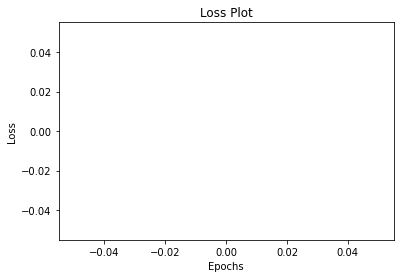

In [57]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

### Model evaluation
The eveluation function is simmilar to the train step, it's only that we are not going to use the teacher forcing and the input of the decoder at each time step is the previous predictions along with the hidden start and the encoder output.

* stop predicting when we reach the `end` token or if the we reach the ,aximum length.

* store the attention weights for every time step.

In [59]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

### Refs

1. [tensorflow tutorial](https://www.tensorflow.org/tutorials/text/image_captioning)

2. [Neural Image Caption Generation with Visual Attention PAPER](https://arxiv.org/abs/1502.03044)